In [1]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import glob
import os
import pandas as pd
import xarray as xr
import netCDF4
from datetime import datetime
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

In [2]:

rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
rgi_mask = gpd.read_file(rgi).to_crs('EPSG:32611')
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
wbd_mask = gpd.read_file(wbd).to_crs('EPSG:32611')
BS = f'/home/etboud/projects/data/basins/BUDD/BUDD_4326.geojson'
#basin = gpd.read_file('/home/etboud/projects/snow_mapping/Emma/budd_rectangle_modis_extent_32611.geojson')
basin = gpd.read_file(BS)

# basin = basin.to_crs(coarse.rio.crs)
# rgi_mask = gpd.read_file(rgi).to_crs(coarse.rio.crs)
# wbd_mask = gpd.read_file(wbd).to_crs(coarse.rio.crs)


# Project Season Netcdf

In [3]:
# Load the reference GeoTIFF
with rasterio.open('/home/etboud/projects/data/masks/BUDD_mask.tif') as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height

In [30]:
# Open netcdf file and rename variable
unprojected_nc = '/data0/images/planet/emma/planet/rerun/BUDD/PP/BUDD_V5PP_2023_3_50_NDVI_QAQC_3.nc'
ds = xr.open_dataset(unprojected_nc)
ds = ds.rename({"__xarray_dataarray_variable__": "data"})
da = ds['data']

# Confirm shape matches GeoTIFF
assert da.shape[-2:] == (ref_height, ref_width), "Data shape doesn't match GeoTIFF shape."

# Step 1: Create real-world coordinates based on transform
# Affine transform: x = a * col + c; y = e * row + f
transform = ref_transform
x_coords = np.arange(ref_width) * transform.a + transform.c
y_coords = np.arange(ref_height) * transform.e + transform.f

# Step 2: Assign coordinates and CRS
da = da.assign_coords(x=("x", x_coords), y=("y", y_coords))
da.rio.write_crs(ref_crs, inplace=True)
da.rio.write_transform(transform, inplace=True)

<xarray.DataArray 'data' (time: 69, y: 1627, x: 914)> Size: 821MB
[102608382 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 552B 2023-04-02 2023-04-04 ... 2023-09-29
  * x            (x) float64 7kB 2.883e+05 2.883e+05 ... 2.91e+05 2.91e+05
  * y            (y) float64 13kB 4.195e+06 4.195e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int64 8B 0

In [31]:
da.to_netcdf('BUDD_V5PP_2023_3_50_NDVI_QAQC_projected.nc')

# Reproject PS to MODSCAG

In [42]:
fine_nc = '/home/etboud/projects/data/stacks/BUDD_baseST_2023_3_50_NDVI_QAQC_smoothing.nc' # this changes for the year you are interested in 
coarse_nc = '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230401_v01.0.nc'

In [43]:
fine = xr.open_dataset(fine_nc)
fine = fine.rio.write_crs('EPSG:32611')
coarse = xr.open_dataset(coarse_nc)
coarse = coarse.rio.write_crs(coarse.crs.proj4)

In [44]:
# Reproject the fine resolution data to match the coarse resolution
fine_projected = fine.rio.reproject_match(coarse, resampling = Resampling.average)

# clip bounds to non nan values
fine = fine_projected.where(~fine_projected.isnull(), drop=True)

In [ ]:
# fine_unprojected = xr.open_dataset(fine_nc).rio.write_crs('EPSG:32611')

### Read in MODIS and clip to PS extent

In [45]:
def read_modis_snowtoday(wy, modis_dir, start_date, end_date):
    

    #mask = ~fine_forced.isnull().any(dim='time')
    
    files = glob.glob(modis_dir + f'*{wy}*nc')
    print(files)
    # select modis file between start and end dates
    dates = [i.split('/')[-1].split('_')[-2] for i in files]
    print(dates)
    files = [files[i] for i, date_str in enumerate(dates)
            if start_date <= pd.to_datetime(date_str) <= end_date]
    files.sort()
    ds_list = []
    print(files)
    sca_list = []
    for f in files[0:]:
        ds = xr.open_dataset(f,engine='netcdf4')
        ds = ds.rio.write_crs(ds.crs.proj4)
        modis_sca = ds['snow_fraction']
        # # Clip coarse to fine_reprojected extent (matching coordinates)
        modis_sca = modis_sca.rio.clip_box(*fine.rio.bounds())
        

        date_str = f.split('/')[-1].split('_')[-2]
        date = pd.to_datetime(date_str)
        
        modis_sca = modis_sca.assign_coords(time=('time', [date]))        

        sca_list.append(modis_sca)

    proj4_str = ds.rio.crs
    combine_ds_sca = xr.concat(sca_list, dim='time')
    combine_ds_sca.rio.write_crs(proj4_str, inplace=True)

    mask = ~fine.isnull().any(dim='time')
    combine_ds_sca = combine_ds_sca.where(mask)  
    
    return combine_ds_sca 


In [46]:
wateryear = 2023
modis_dir = '/data0/images/STC_MODSCG/h08v05/'
start_date = pd.to_datetime(f'{wateryear}-04-01')
end_date = pd.to_datetime(f'{wateryear+1}-09-30')

In [47]:
modis_sca_ds = read_modis_snowtoday(
    wy=wateryear,
    modis_dir=modis_dir,
    start_date=start_date,
    end_date=end_date
) 

['/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230417_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230401_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230916_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230404_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230421_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230826_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230908_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230601_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230708_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230903_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230905_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230918_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST

# Reproject MODIS to planet

In [111]:
def read_modis_albedo_snowtoday(wy, modis_dir, start_date, end_date):
    
    files = glob.glob(modis_dir + f'*{wy}*nc')
    print(files)
    # select modis file between start and end dates
    dates = [i.split('/')[-1].split('_')[-2] for i in files]
    print(dates)
    files = [files[i] for i, date_str in enumerate(dates)
            if start_date <= pd.to_datetime(date_str) <= end_date]
    files.sort()
    ds_list = []
    print(files)
    sca_list = []
    for f in files[0:]:
        ds = xr.open_dataset(f,engine='netcdf4')

        modis_sca = ds['snow_fraction']

        date_str = f.split('/')[-1].split('_')[-2]
        date = pd.to_datetime(date_str)

        modis_sca = modis_sca.assign_coords(ds.coords)
        modis_sca = modis_sca.assign_coords(time=('time', [date]))


        sca_list.append(modis_sca)

    proj4_str = ds.crs.proj4

    combine_ds_sca = xr.concat(sca_list, dim='time')
    combine_ds_sca.rio.write_crs(proj4_str, inplace=True)
    return combine_ds_sca 

In [257]:
wateryear = 2022 # this changes for the year you are interested in 
modis_dir = '/data0/images/STC_MODSCG/h08v05/'
start_date = pd.to_datetime(f'{wateryear}-04-01')
end_date = pd.to_datetime(f'{wateryear+1}-09-30')
model_ir = fine

In [258]:

modis_sca_ds = read_modis_albedo_snowtoday(
    wy=wateryear,
    modis_dir=modis_dir,
    start_date=start_date,
    end_date=end_date
) 

# reproject match modis to model domain and resolution -- maybe too large
modis_sca_ds = modis_sca_ds.rio.reproject_match(model_ir)

['/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220102_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220919_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220809_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220210_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220810_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220129_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220902_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220629_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220509_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220331_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220308_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220303_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST

In [259]:
# Ensure CRS of basin matches repo_modis_sca
basin = f'/home/etboud/projects/data/basins/BUDD/BUDD_4326.geojson'
rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
basin = gpd.read_file(basin).to_crs(modis_sca_ds.rio.crs)
rgi_mask = gpd.read_file(rgi).to_crs(modis_sca_ds.rio.crs)
wbd_mask = gpd.read_file(wbd).to_crs(modis_sca_ds.rio.crs)
modis_sca_ds = modis_sca_ds.rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)

# FIGURES

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid

In [87]:
modis_df = []
for t in range(len(modis_sca_ds.time)):
    modis_slice = modis_sca_ds.isel(time=t).to_dataarray()
    fsca = np.nansum(modis_slice) / np.count_nonzero(~np.isnan(modis_slice))
    modis_df.append(fsca)
    
#create dataframe with fsca_list and corresponding dates
dates = pd.to_datetime(modis_sca_ds.time.values)
modis_fsca_df = pd.DataFrame({'date': dates, 'fsca': modis_df})

In [93]:
modis_sca_ds.data

<xarray.DataArray 'data' (time: 119, y: 11, x: 20)> Size: 105kB
array([[[ nan,  nan,  nan, ...,  96.,  74.,  64.],
        [ nan,  nan,  nan, ...,  71.,  nan,  nan],
        [ nan,  nan,  nan, ...,  91.,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  97.,  97., ...,  nan,  nan,  nan],
        [ 98.,  98.,  99., ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  97.,  76.,  55.],
        [ nan,  nan,  nan, ...,  76.,  nan,  nan],
        [ nan,  nan,  nan, ...,  91.,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  97.,  97., ...,  nan,  nan,  nan],
        [ 98.,  99., 100., ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  97.,  79.,  50.],
        [ nan,  nan,  nan, ...,  78.,  nan,  nan],
        [ nan,  nan,  nan, ...,  91.,  nan,  nan],
        ...,
...
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,   0.,   0., ...,  nan,  nan,  nan],
        [  0.,   0.,   0., ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,  nan,  nan],
        [ nan,  nan,  nan, ...,   0.,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,   0.,   0., ...,  nan,  nan,  nan],
        [  0.,   0.,   0., ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,  nan,  nan],
        [ nan,  nan,  nan, ...,   0.,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,   0.,   0., ...,  nan,  nan,  nan],
        [  0.,   0.,   0., ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 160B -1.049e+07 -1.049e+07 ... -1.048e+07
  * y            (y) float64 88B 4.212e+06 4.211e+06 ... 4.208e+06 4.207e+06
  * time         (time) datetime64[ns] 952B 2023-04-01 2023-04-02 ... 2023-09-30
    crs          int64 8B 0
    spatial_ref  int64 8B 0
Attributes:
    long_name:       STC-MODSCAG on the ground snow fraction
    units:           %
    valid_range:     [  0 100]
    comment:         Viewable snow fraction adjusted for canopy obstruction u...
    snowtoday_id:    40.0
    snowtoday_name:  snow_fraction
    standard_name:   surface_snow_area_fraction

In [30]:
planet_df = []
for t in range(len(fine.time)):
    planet_slice = fine.isel(time=t).to_dataarray()
    fsca = (np.nansum(planet_slice) / np.count_nonzero(~np.isnan(planet_slice)))*100
    planet_df.append(fsca)
    
#create dataframe with fsca_list and corresponding dates
dates = pd.to_datetime(fine.time.values)
planet_fsca_df = pd.DataFrame({'date': dates, 'fsca': planet_df})

In [75]:
aso_nc = f'/home/etboud/projects/data/stacks/extra/BUDD_aso_projected.nc'
aso = xr.open_dataset(aso_nc)
aso_df = []
for t in range(len(aso.time)):
    aso_slice = aso['data'].isel(time=t)
    fsca = (np.nansum(aso_slice) / np.count_nonzero(~np.isnan(aso_slice)))*100
    aso_df.append(fsca)
#create dataframe with fsca_list and corresponding dates
dates = pd.to_datetime(aso.time.values)
aso_fsca_df = pd.DataFrame({'date': dates, 'fsca': aso_df})
aso_fsca_df['date'] = pd.to_datetime(aso_fsca_df['date'])


In [80]:
# aso_fsca_df['aso_date'] = aso_fsca_df['date']
# #sort by date
# aso_fsca_df = aso_fsca_df.sort_values(by='date')
# aso_fsca_df['date'] = pd.to_datetime(['2022-04-03','2022-04-30','2022-05-18','2023-04-26','2023-06-01','2023-06-29'], errors='coerce')
# # add row to aso_fsca_df with 	2022-04-07	90.291285	2022-04-05
# app_df = pd.DataFrame([['2022-04-07', 90.291285, '2022-04-05']], columns = ['date', 'fsca', 'aso_date'])
# aso_fsca_df['date'] = pd.to_datetime(aso_fsca_df['date'])
aso_merged_df = pd.merge(aso_fsca_df, modis_fsca_df,on='date', suffixes=('_modis', '_aso'))
# # concat app df to aso_fsca_df
# aso_fsca_df = pd.concat([aso_fsca_df, app_df], ignore_index=True)
# # # ensure all dates are in datetime format
# aso_fsca_df['date'] = pd.to_datetime(aso_fsca_df['date'], errors='coerce')
# # sort by date
# aso_fsca_df = aso_fsca_df.sort_values(by='date')

In [83]:
aso_fsca_df

,date,fsca
0,2022-04-29,93.839752
1,2022-05-18,60.342768
2,2023-04-27,96.632297
3,2023-06-01,94.044866
4,2023-06-26,78.318644
5,2022-04-05,90.291285
6,2020-04-13,98.892266
7,2020-05-07,73.526780
8,2020-05-21,46.019115


In [33]:
# merge modis oon ps dates
modis_fsca_df['date'] = pd.to_datetime(modis_fsca_df['date'])
planet_fsca_df['date'] = pd.to_datetime(planet_fsca_df['date'])
merged_df = pd.merge(modis_fsca_df, planet_fsca_df, on='date', suffixes=('_modis', '_ps'))

In [34]:
merged_2023 = merged_df # need individual dataframe for each year
# merged_2022 = merged_df

In [91]:
print(modis_fsca_df.date[20:60])

20   2023-04-21
21   2023-04-22
22   2023-04-23
23   2023-04-24
24   2023-04-25
25   2023-04-26
26   2023-06-01
27   2023-06-29
28   2023-07-02
29   2023-07-03
30   2023-07-04
31   2023-07-05
32   2023-07-06
33   2023-07-07
34   2023-07-08
35   2023-07-09
36   2023-07-10
37   2023-07-11
38   2023-07-12
39   2023-07-13
40   2023-07-14
41   2023-07-15
42   2023-07-16
43   2023-07-17
44   2023-07-18
45   2023-07-19
46   2023-07-20
47   2023-07-21
48   2023-07-22
49   2023-07-23
50   2023-07-24
51   2023-07-25
52   2023-07-26
53   2023-07-27
54   2023-07-28
55   2023-07-29
56   2023-07-30
57   2023-07-31
58   2023-08-01
59   2023-08-02
Name: date, dtype: datetime64[ns]


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

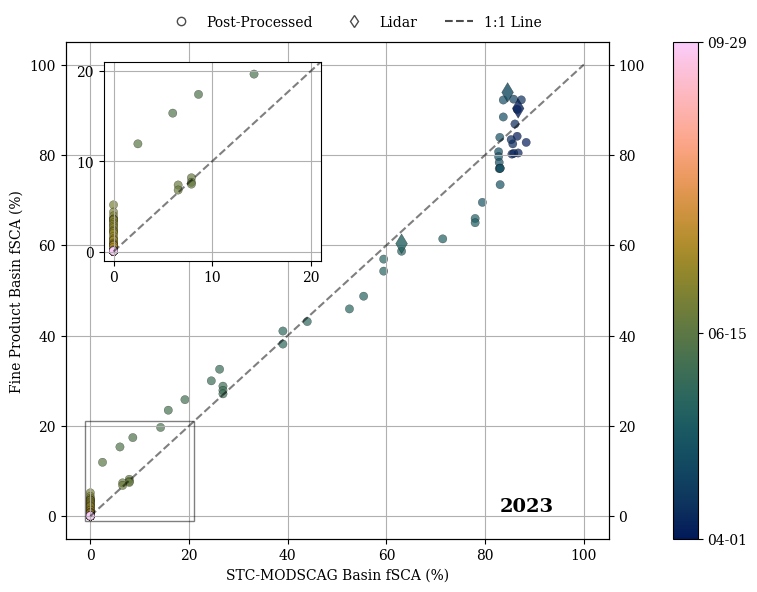

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D


# If 'date' is not in datetime format, convert it
planet_fsca_df["date"] = pd.to_datetime(planet_fsca_df["date"], errors="coerce")

# Define seasonal start and end in MM-DD format (no year!)
season_start = (4, 1)  # April 1
season_end = (9, 29)   # September 29

# Function to convert a date to "day of season" index
def day_of_season(date):
    # Treat all dates as year-agnostic, use a reference leap-safe year
    dummy_year = 2001
    start = pd.Timestamp(f"{dummy_year}-{season_start[0]:02d}-{season_start[1]:02d}")
    current = pd.Timestamp(f"{dummy_year}-{date.month:02d}-{date.day:02d}")
    return (current - start).days

# Apply the function to both dataframes
merged_df['day_of_season'] = merged_df['date'].apply(day_of_season)
aso_merged_df['day_of_season'] = aso_merged_df['date'].apply(day_of_season)

# Set up shared color scale
vmin, vmax = 0, day_of_season(pd.Timestamp(f"2001-{season_end[0]:02d}-{season_end[1]:02d}"))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cmc.batlow

# Generate colors
colors_ps= cmap(norm(merged_df['day_of_season']))
colors_aso = cmap(norm(aso_merged_df['day_of_season']))


plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
scatter = ax.scatter(
    merged_df['fsca_modis'],
    merged_df['fsca_ps'],
    c=colors_ps,
    label = 'Post-Processed',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)

# add inset zoomed in
axins = ax.inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins.scatter(
    merged_df['fsca_modis'],
    merged_df['fsca_ps'],
    c=colors_ps,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# Set limits for the inset
axins.set_xlim(-1, 21)
axins.set_ylim(-1, 21)
axins.set_xticks([0, 10,20])#.20,30])
axins.set_yticks([0, 10,20])#,20,30])
# Add grid to the inset
axins.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 21, 0, 21
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)
# draw lines on inset
axins.plot([0, 21], [0, 21], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)


axins2 = ax2.scatter(aso_merged_df['fsca_modis'], 
                    aso_merged_df['fsca_aso'], 
                    marker = 'd',s = 100,color=colors_aso,
                    alpha=0.8, edgecolor='k', linewidth=0.2, label = 'Lidar')
ax2.set_ylim(-5, 105)
#ax2.set_ylabel('Lidar Basin fSCA (%)')
# Add colorbar to show date mapping
sm = cm.ScalarMappable(cmap=cmc.batlow, norm=norm)
sm.set_array([])

# add 1 to 1 line
x = np.linspace(0, 100, 100)
y = x
line = ax.plot(x, y, color='black', alpha = .5, linestyle='--', label='1:1 Line')[0]
# Labeling
ax.set_xlabel('STC-MODSCAG Basin fSCA (%)')
ax.set_ylabel('Fine Product Basin fSCA (%)')
# ax.set_title('2023')
ax.text(0.8, 0.055, '2023', transform=ax.transAxes, fontsize=14, fontweight='bold')

# Create ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add one colorbar for both plots
# Create a new axis for the colorbar
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.09)

# Set MM-DD labels for selected ticks
tick_days = [0, 75, 181]  # Approx. Apr 1, mid-June, Sept 29
tick_labels = ['04-01', '06-15', '09-29']
cbar.set_ticks(tick_days)
cbar.set_ticklabels(tick_labels)



# Custom legend handles with black color
custom_handles = [
    Line2D([0], [0], marker='o', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Post-Processed'),
    Line2D([0], [0], marker='d', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Lidar'),
    Line2D([0], [0], color='black', linestyle='--', alpha=.7, label='1:1 Line')
]
# Now pass them to the main legend
ax.legend(custom_handles, [h.get_label() for h in custom_handles], bbox_to_anchor=(.9, 1.08), ncol=3, fontsize=10, frameon=False)
#ax.legend(bbox_to_anchor = (0.8,1.1), ncol = 3, fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid
# If 'date' is not in datetime format, convert it
planet_fsca_df["date"] = pd.to_datetime(planet_fsca_df["date"], errors="coerce")

# Define seasonal start and end in MM-DD format (no year!)
season_start = (4, 1)  # April 1
season_end = (9, 29)   # September 29

# Function to convert a date to "day of season" index
def day_of_season(date):
    # Treat all dates as year-agnostic, use a reference leap-safe year
    dummy_year = 2001
    start = pd.Timestamp(f"{dummy_year}-{season_start[0]:02d}-{season_start[1]:02d}")
    current = pd.Timestamp(f"{dummy_year}-{date.month:02d}-{date.day:02d}")
    return (current - start).days

# Apply the function to both dataframes
merged_2022['day_of_season'] = merged_2022['date'].apply(day_of_season)
merged_2023['day_of_season'] = merged_2023['date'].apply(day_of_season)
aso_merged_2022['day_of_season'] = aso_merged_df['date'].apply(day_of_season)
aso_merged_2023['day_of_season'] = aso_merged_df['date'].apply(day_of_season)

# Set up shared color scale
vmin, vmax = 0, day_of_season(pd.Timestamp(f"2001-{season_end[0]:02d}-{season_end[1]:02d}"))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cmc.batlow

# Generate colors
colors_2022 = cmap(norm(merged_2022['day_of_season']))
colors_2023 = cmap(norm(merged_2023['day_of_season']))
colors_aso_2022 = cmap(norm(aso_merged_2022['day_of_season']))
colors_aso_2023 = cmap(norm(aso_merged_2023['day_of_season']))

plt.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(12, 12))

ax = ImageGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=.1,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

ax[0].scatter(
    merged_2022['fsca_modis'],
    merged_2022['fsca_ps'],
    c=colors_2022,

    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# insert text 
ax[0].text(0.8, 0.055, '2022', transform=ax[0].transAxes, fontsize=14, fontweight='bold')
# add inset zoomed in
axins0 = ax[0].inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins0.scatter(
    merged_2022['fsca_modis'],
    merged_2022['fsca_ps'],
    c=colors_2022,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
twin1 = ax[0].scatter(aso_merged_2022['fsca_modis'], 
                    aso_merged_2022['fsca_aso'], 
                    marker = 'd',s = 100,color=colors_aso,
                    alpha=0.8, edgecolor='k', linewidth=0.2, label = 'Lidar')
# Set limits for the inset
axins0.set_xlim(-1, 35)
axins0.set_ylim(-1, 35)
axins0.set_xticks([0, 10,20,30])
axins0.set_yticks([0, 10,20,30])
# Add grid to the inset
axins0.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 10, 0, 10
ax[0].indicate_inset_zoom(axins0, edgecolor="black", alpha=0.5)
# draw lines on inset
axins0.plot([0, 35], [0, 35], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)


ax[1].scatter(
    merged_2023['fsca_modis'],
    merged_2023['fsca_ps'],
    c=colors_2023,

    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# insert text 
ax[1].text(0.8, 0.055, '2023', transform=ax[1].transAxes, fontsize=14, fontweight='bold')
# add inset zoomed in
axins1= ax[1].inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins1.scatter(
    merged_2023['fsca_modis'],
    merged_2023['fsca_ps'],
    c=colors_2023,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)


twin2 = ax[1].scatter(aso_merged_2023['fsca_modis'], 
                    aso_merged_2023['fsca_aso'], 
                    marker = 'd',s = 100,color=colors_aso,
                    alpha=0.8, edgecolor='k', linewidth=0.2, label = 'Lidar')
ax2.set_ylim(-5, 105)

# Set limits for the inset
axins1.set_xlim(-1, 35)
axins1.set_ylim(-1, 35)
axins1.set_xticks([0, 10,20,30])
axins1.set_yticks([0, 10,20,30])
# Add grid to the inset
axins1.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 10, 0, 10
ax[1].indicate_inset_zoom(axins1, edgecolor="black", alpha=0.5)
# draw lines on inset
axins1.plot([0, 35], [0, 35], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)




# # Add colorbar to show date mapping
# sm = cm.ScalarMappable(cmap=cmc.batlow, norm=norm)
# sm.set_array([])
# # cbar = plt.colorbar(sm, ax.cbar_axes[0])
#cbar.set_label('Date')
# add 1 to 1 line
x = np.linspace(0, 100, 100)
y = x
for axis in [ax[0], ax[1]]:
    axis.plot(x, y, color='black', alpha=0.5, linestyle='--', label='1:1 Line')
    # Labeling
    axis.set_xlabel('STC-MODSCAG Basin fSCA (%)')
    axis.set_ylabel('Basin fSCA (%)')


# Create ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add one colorbar for both plots
cbar = fig.colorbar(sm, cax=ax.cbar_axes[0], orientation='vertical')

# Set MM-DD labels for selected ticks
tick_days = [0, 75, 181]  # Approx. Apr 1, mid-June, Sept 29
tick_labels = ['04-01', '06-15', '09-29']
cbar.set_ticks(tick_days)
cbar.set_ticklabels(tick_labels)

for axis in ax:
    axis.grid(True)
    
    
# Custom legend handles with black color
custom_handles = [
    Line2D([0], [0], marker='o', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Post-Processed'),
    Line2D([0], [0], marker='d', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Lidar'),
    Line2D([0], [0], color='black', linestyle='--', alpha=.7, label='1:1 Line')
]
# Now pass them to the main legend
# Add the legend to the first axis in the grid
ax[0].legend(custom_handles, [h.get_label() for h in custom_handles], bbox_to_anchor=(1.4, 1.08), ncol=3, fontsize=10, frameon=False)

    
plt.tight_layout()
plt.show()
# save figure
fig.savefig('/home/etboud/projects/ps_sca/BUDD_2022_2023_scatter_modis_reprojected.png', dpi=400, bbox_inches='tight')

In [3]:
# Masks to use to look at different pixel groups
can_fn = f'/home/etboud/projects/data/masks/4b_15img_ndvi_45_85_BUDD_notclipped.tif'
op_fn = f'/home/etboud/projects/data/masks/4b_15img_ndvi_open_BUDD.tif' # 
all_fn = f'/home/etboud/projects/data/masks/BUDD_mask.tif'
can_mask = rxr.open_rasterio(can_fn)
can_mask.values = np.where(can_mask.values>0, 0, np.nan)

In [ ]:

# calculate the rgb bands and normalize radiances
# see 1_classify_train_model.ipynb
def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

focus_year = 2022
data_direc = f'/data0/images/planet/emma/planet/BUDD/'
subdirecs = sorted([d for d in glob.glob(data_direc + str(focus_year) + '*') if os.path.isdir(d)])
for dCount,direcc in enumerate(subdirecs):
    if '202205' in direcc:
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        code = direcc.split('/')[-1]
        rgb_image = rxr.open_rasterio(fname)
        _,_,_,_,rgb_image = calc_rgb(rgb_image)
        fg,ax = plt.subplots(1,1)
        ax = np.ravel(ax)
        ax[0].imshow(rgb_image,cmap='gray')

        # ax[0].imshow(can_mask.squeeze())
        # make abckground white
        ax[0].set_facecolor('white')
        ax[0].set_title(code)
        # ax[0].set_xlim(0,800)
        # ax[0].set_ylim(1700,900)
        # remove axis
        ax[0].axis('off')
        plt.show()


/tmp/ipykernel_3025425/3669197820.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave room for colorbar on the right


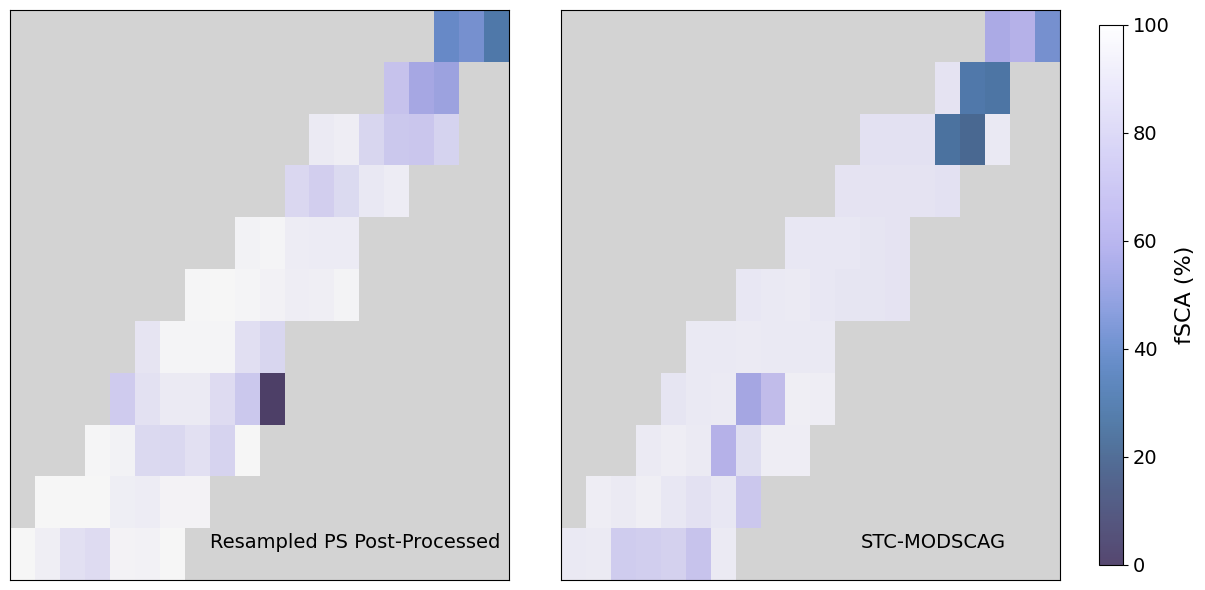

In [52]:
# Create figure and two side-by-side axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Increase width if needed

# Plot on each axis
fine_plot = fine.sel(time='2022-04-30').to_dataarray().plot(
    cmap=cmc.devon, vmin=0, vmax=1, alpha=0.8, ax=ax[0], add_colorbar=False
)
modis_plot = modis_sca_ds.sel(time='2022-04-30').to_dataarray().plot(
    cmap=cmc.devon, vmin=0, vmax=100, alpha=0.8, ax=ax[1], add_colorbar=False
) # .to_dataaray()

# Create a new axis for the colorbar that doesn't shrink ax[1]
# [left, bottom, width, height] in figure coordinates
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])  # adjust as needed

# Add the colorbar to the new axis
cbar = fig.colorbar(modis_plot, cax=cbar_ax, orientation='vertical')
cbar.set_label('fSCA (%)', fontsize=16)
#make ticks larger
cbar.ax.tick_params(labelsize=14)

# # Optional: turn off axes
# ax[0].axis('off')
# ax[1].axis('off')
# cahnge abckground color to light grey
ax[0].set_facecolor('lightgrey')
ax[1].set_facecolor('lightgrey')
#remove ticck marks, titles and labels
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title('')
    axis.set_xlabel('')
    axis.set_ylabel('')
# # add a and b in the first and second subplot
# ax[0].text(0.05, 0.95, '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
# ax[1].text(0.05, 0.95, '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')
    
# add a and b in the first and second subplot
ax[0].text(0.4, 0.05, 'Resampled PS Post-Processed', transform=ax[0].transAxes, fontsize=14, va='bottom')
ax[1].text(0.6, 0.05, 'STC-MODSCAG', transform=ax[1].transAxes, fontsize=14, va='bottom')
    
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave room for colorbar on the right
plt.show()
# save figure
#fig.savefig('PS_proj_20220430_modscag_reprojected.png', dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates

# plot the timeseries of each combination of threshold and radius
fig, ax = plt.subplots(figsize=(11, 6))
plt.rcParams['font.family'] = 'serif'
#num_lines = len(ps_fsca_data['threshold'].unique())  # however many lines you need to plot
# Get evenly spaced colors from the batlow colormap
# colors = cmc.batlow(np.linspace(0, 1, num_lines))
# i = 0  # Initialize color index
# for radius in ps_fsca_data['radius'].unique():
#     for threshold in np.sort(ps_fsca_data['threshold'].unique()):
#         subset = ps_fsca_data[(ps_fsca_data['radius'] == radius) & (ps_fsca_data['threshold'] == threshold)]
#         ax.plot(subset['date'], subset['fsca'], color=colors[i], label=f'Radius: {radius}, Threshold: {threshold}')
#         i += 1  # Increment color index
# Add an inset zoomed in on the range from 2022-06 to 2022-07

axins = ax.inset_axes([0.45, 0.45, 0.5, 0.5])  # [x, y, width, height]
for df, label, color in zip(
    [p_V7_fsca_df, p_V5_fsca_df, p_V9_fsca_df, pp_fsca_df, modis_fsca_df, aso_df],
    ['Pflug et al.', 'Yang et al.', 'Composite', 'PP Yang et al.', 'STC-MODSCAG'],
    ['crimson', 'darkorange', 'darkkhaki', 'cadetblue', 'thistle']
):
    axins.plot(df['date'], df['fsca'], label=label, color=color, linewidth=1.2)

# Set limits for the inset
axins.set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31'))
axins.set_ylim(-2, 35)

# Format the x-axis of the inset
#axins.xaxis.set_major_formatter(DateFormatter('%b-%d'))
# only show every 2nd date
axins.xaxis.set_major_locator(mdates.DayLocator(interval=15))

# Add grid and labels to the inset
axins.grid(False)
#axins.set_title('Zoom: Jun-Jul 2022', fontsize=10)
# mark wher eon major axis the zoomed in box is
# x1, x2, y1, y2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31'), -2, 35
# ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.2)


# x1, x2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31')
# y1, y2 = -2, 35
# from matplotlib.patches import Rectangle
# # Draw rectangle manually on main axes (zoom area)
# rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='black', facecolor='none', alpha=0.5, lw=.5)
# ax.add_patch(rect)


ax.plot(p_V7_fsca_df['date'], p_V7_fsca_df['fsca'], label='Pflug et al.', color='crimson', linewidth=1.2)
ax.plot(p_V5_fsca_df['date'], p_V5_fsca_df['fsca'], label='Yang et al.', color='darkorange', linewidth=1.2)
ax.plot(p_V9_fsca_df['date'], p_V9_fsca_df['fsca'], label='Composite', color='darkkhaki', linewidth=1.2)
ax.plot(pp_fsca_df['date'], pp_fsca_df['fsca'], label='PP Yang et al.', color='cadetblue', linewidth=1.2)        
ax.plot(modis_fsca_df['date'], modis_fsca_df['fsca'], label='STC-MODSCAG', color='thistle', linewidth=1.2)
ax.scatter(aso_df['date'], aso_df['fsca'], label='ASO',marker = 'o', alpha = .8, c='darkslategrey', s=60, edgecolors='black')
#ax.plot(aso_df['date'], aso_df['fsca'], label='ASO',c='darkslategrey')
ax.legend(loc='lower left', fontsize=12)
ax.set_ylabel('Basin Snow Covered Area (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

In [5]:
streamflow = pd.read_csv('/home/etboud/projects/tum_hydro_qc/unvented_2022/data/barocorrected/BuddCreek_2022_barocorrected_0.csv')

In [11]:
streamflow = streamflow[streamflow['date_time(UTC:PDT+7)'] > '2022-04-01']

In [ ]:
years = ['2022','2023']
combine_df = []
for year in years:
    fine_nc = f'BUDD_V5PP_{year}_3_50_NDVI_QAQC_projected.nc' # this changes for the year you are interested in 
    fine = xr.open_dataset(fine_nc)
    fine = fine.rio.write_crs('EPSG:32611')
    planet_df = []
    for t in range(len(fine.time)):
        planet_slice = fine.isel(time=t).to_dataarray()
        fsca = (np.nansum(planet_slice) / np.count_nonzero(~np.isnan(planet_slice)))*100
        planet_df.append(fsca)
        
    #create dataframe with fsca_list and corresponding dates
    dates = pd.to_datetime(fine.time.values)
    planet_fsca_df = pd.DataFrame({'date': dates, 'fsca': planet_df})
    combine_df.append(planet_fsca_df)
combine_df = pd.concat(combine_df)

In [15]:
df_2022 = pd.read_csv('/home/etboud/projects/tum_hydro_qc/unvented_2022/data/barocorrected/BuddCreek_2022_barocorrected_0.csv')
df_2023 = pd.read_csv('/home/etboud/projects/tum_hydro_qc/unvented_2023/data/barocorrected/BuddCreek_2023_barocorrected_0.csv')
df_2020 = pd.read_csv('/home/etboud/projects/tum_hydro_qc/unvented_2020/data/barocorrected_joe/BuddCreek_2020_barocorrected_0.csv')

multi_df = pd.concat([df_2020,df_2022,df_2023])

# Define the function to calculate day of water year
def get_dowy(date):
    water_year_start = pd.Timestamp(year=date.year, month=10, day=1)
    if date < water_year_start:
        water_year_start = pd.Timestamp(year=date.year - 1, month=10, day=1)
    return (date - water_year_start).days + 1

def dowy_to_date(water_year_start, dowy):
    return water_year_start + pd.Timedelta(days=dowy - 1)

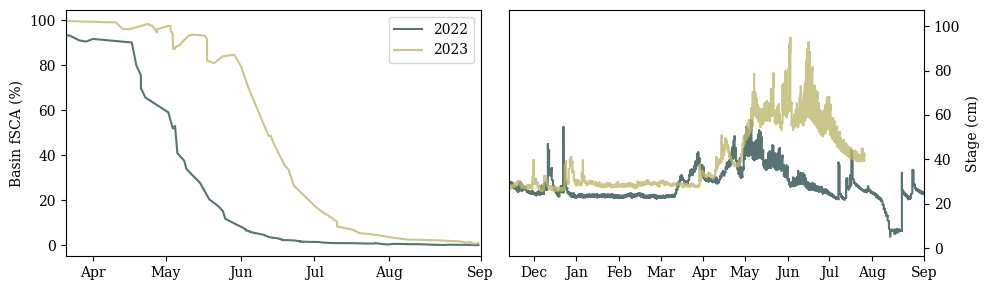

In [57]:
year_list = ['2022', '2023']
flow = multi_df
colors = ['darkslategrey', 'darkkhaki']
# Set up the figure and subplots
fig, ax = plt.subplots(1,2,figsize=(10, 3))

if 'date' in combine_df.columns:
    combine_df['date'] = pd.to_datetime(combine_df['date'])
    combine_df.set_index('date', inplace=True)
    combine_df['dowy'] = combine_df.index.to_series().apply(get_dowy)
    
for i, year in enumerate(year_list):
    start_date = pd.Timestamp(year=int(year) - 1, month=10, day=1)
    end_date = pd.Timestamp(year=int(year), month=9, day=30)
    fsca_year_data = combine_df.loc[start_date:end_date]
    
    if not fsca_year_data.empty:
        ax[0].plot(fsca_year_data['dowy'], fsca_year_data['fsca'], color=colors[i], alpha =.8, label=f'{year}')    
    
if 'date_time(UTC:PDT+7)' in flow.columns:
    flow['date_time(UTC:PDT+7)'] = pd.to_datetime(flow['date_time(UTC:PDT+7)'])
    flow.set_index('date_time(UTC:PDT+7)', inplace=True)
    flow['dowy'] = flow.index.to_series().apply(get_dowy)
    
# Plotting

for i, year in enumerate(year_list):
    start_date = pd.Timestamp(year=int(year) - 1, month=10, day=1)
    end_date = pd.Timestamp(year=int(year), month=9, day=30)
    flow_year_data = flow.loc[start_date:end_date]
    
    if not flow_year_data.empty:
        ax[1].plot(flow_year_data['dowy'], flow_year_data['barocorrected_pressure(cm)'], color=colors[i], alpha =.8)

#ax[1].set_title('Budd Creek Stage (cm)')

ax[1].set_ylabel('Stage (cm)')
for subplot in [ax[0], ax[1]]:
    # Set x-ticks to be associated with dates
    xticks = [1, 32, 64, 97, 130, 162, 195, 227, 260, 292, 325, 365]  # Example dowy values for tick positions
    xticks_dates = [dowy_to_date(pd.Timestamp(year=int(year) - 1, month=10, day=1), dowy) for dowy in xticks]
    subplot.set_xticks(xticks)
    subplot.set_xticklabels([date.strftime('%b') for date in xticks_dates])

    
    subplot.grid(False)
    if subplot == ax[1]:

        subplot.set_xlim(45, 365)
    if subplot == ax[0]:
        #subplot.set_title('Budd Creek Basin fSCA (%)')
        subplot.set_xlim(183, 365)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].legend(loc='upper right')    
ax[0].set_ylabel('Basin fSCA (%)')
# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
name = 'BUDD'
year = '2020'
p5 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V5_{year}_model_output.nc')

p_V5_fsca_list = []
for i, date in enumerate(p5.time.values):
    p_slice = p5.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V5_fsca_list.append(fsca)
dates = pd.to_datetime(p5.time.values)
p_V5_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V5_fsca_list})

p9 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V9_{year}_model_output.nc')

p_V9_fsca_list = []
for i, date in enumerate(p9.time.values):
    p_slice = p9.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V9_fsca_list.append(fsca)
dates = pd.to_datetime(p9.time.values)
p_V9_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V9_fsca_list})

p7 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V7_{year}_model_output.nc')

p_V7_fsca_list = []
for i, date in enumerate(p7.time.values):
    p_slice = p7.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V7_fsca_list.append(fsca)
dates = pd.to_datetime(p7.time.values)
p_V7_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V7_fsca_list})

pp = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V5PP_{year}_3_50_NDVI_QAQC_3.nc')

pp_fsca_list = []
for i, date in enumerate(pp.time.values):
    p_slice = pp.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    pp_fsca_list.append(fsca)
dates = pd.to_datetime(pp.time.values)
pp_fsca_df = pd.DataFrame({'date': dates, 'fsca': pp_fsca_list})


In [13]:
pp_fsca_df

,date,fsca
0,2020-03-26,83.948355
1,2020-04-01,72.483459
2,2020-04-07,70.513288
3,2020-04-11,65.970919
4,2020-04-13,65.959164
...,...,...
86,2020-09-23,0.029088
87,2020-09-23,0.029088
88,2020-09-24,0.028128
89,2020-09-24,0.028128


In [109]:
#aso in 2023 sorted
aso_fsca_df= aso_fsca_df[aso_fsca_df['date'] > '2023-01-01'].sort_values(by='date', ascending=True) #<

In [113]:
p_V7_fsca_df.loc[p_V7_fsca_df['fsca'] > 100, 'fsca'] = 100

(19448.0, 19629.0)

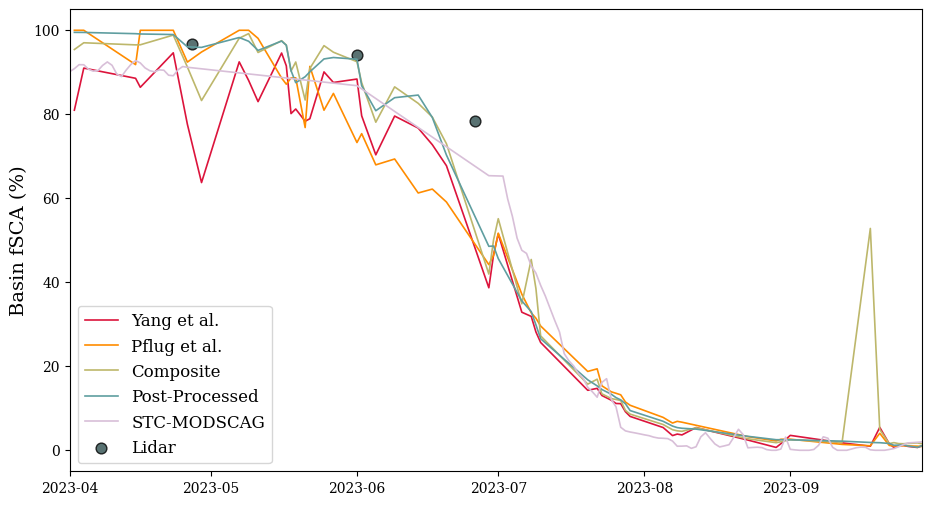

In [130]:
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates

# plot the timeseries of each combination of threshold and radius
fig, ax = plt.subplots(figsize=(11, 6))
plt.rcParams['font.family'] = 'serif'
# num_lines = len(ps_fsca_data['threshold'].unique())  # however many lines you need to plot
# # Get evenly spaced colors from the batlow colormap
# colors = cmc.batlow(np.linspace(0, 1, num_lines))
# i = 0  # Initialize color index
# for radius in ps_fsca_data['radius'].unique():
#     for threshold in np.sort(ps_fsca_data['threshold'].unique()):
#         subset = ps_fsca_data[(ps_fsca_data['radius'] == radius) & (ps_fsca_data['threshold'] == threshold)]
#         ax.plot(subset['date'], subset['fsca'], color=colors[i], label=f'Radius: {radius}, Threshold: {threshold}')
#         i += 1  # Increment color index
# # Add an inset zoomed in on the range from 2022-06 to 2022-07

# axins = ax.inset_axes([0.55, 0.46, 0.44, 0.5])  # [x, y, width, height]
# for df, label, color in zip(
#     [p_V7_fsca_df, p_V5_fsca_df, p_V9_fsca_df, pp_fsca_df, modis_fsca_df, aso_df],
#     ['Pflug et al.', 'Yang et al.', 'Composite', 'Post-Processed', 'STC-MODSCAG'],
#     ['crimson', 'darkorange', 'darkkhaki', 'cadetblue', 'thistle']
# ):
#     axins.plot(df['date'], df['fsca'], label=label, color=color, linewidth=1.2)

# # Set limits for the inset
# axins.set_xlim(pd.to_datetime('2023-07-01'), pd.to_datetime('2023-09-30'))
# axins.set_ylim(-2, 35)

# # Format the x-axis of the inset
# axins.xaxis.set_major_formatter(DateFormatter('%b-%d'))
# # only show every 2nd date
# axins.xaxis.set_major_locator(mdates.DayLocator(interval=15))

# # Add grid and labels to the inset
# axins.grid(False)
#axins.set_title('Zoom: Jun-Jul 2022', fontsize=10)
# mark wher eon major axis the zoomed in box is
# x1, x2, y1, y2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31'), -2, 35
# ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.2)


# x1, x2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31')
# y1, y2 = -2, 35
# from matplotlib.patches import Rectangle
# # Draw rectangle manually on main axes (zoom area)
# rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='black', facecolor='none', alpha=0.5, lw=.5)
# ax.add_patch(rect)

ax.plot(p_V5_fsca_df['date'], p_V5_fsca_df['fsca'], label='Yang et al.', color='crimson', linewidth=1.2)
ax.plot(p_V7_fsca_df['date'], p_V7_fsca_df['fsca'], label='Pflug et al.', color='darkorange', linewidth=1.2)
ax.plot(p_V9_fsca_df['date'], p_V9_fsca_df['fsca'], label='Composite', color='darkkhaki', linewidth=1.2)
ax.plot(pp_fsca_df['date'], pp_fsca_df['fsca'], label='Post-Processed', color='cadetblue', linewidth=1.2)        
ax.plot(modis_fsca_df['date'], modis_fsca_df['fsca'], label='STC-MODSCAG', color='thistle', linewidth=1.2)
ax.scatter(aso_fsca_df['date'], aso_fsca_df['fsca'], label='Lidar',marker = 'o', alpha = .8, c='darkslategrey', s=60, edgecolors='black')
#ax.plot(aso_df['date'], aso_df['fsca'], label='ASO',c='darkslategrey')
ax.legend(loc='lower left', fontsize=12)
ax.set_ylabel('Basin fSCA (%)', fontsize=14)
ax.set_ylim(-5, 105)
ax.set_xlim(pd.to_datetime('2023-04-01'), pd.to_datetime('2023-09-29'))
#ax.set_xlabel('Date', fontsize=14)
# save figure
# fig.savefig('/home/etboud/projects/ps_sca/BUDD_2022_timeseries.png', dpi=400, bbox_inches='tight')

In [51]:
modis_fsca_df

,date,fsca
0,2022-04-01,85.420635
1,2022-04-02,85.845238
2,2022-04-03,85.920635
3,2022-04-04,85.126984
4,2022-04-05,84.123016
...,...,...
178,2022-09-26,0.000000
179,2022-09-27,0.000000
180,2022-09-28,0.000000
181,2022-09-29,0.000000


In [107]:
p_V5_fsca_df

,date,fsca
0,2022-03-30,72.900404
1,2022-04-01,63.367295
2,2022-04-03,52.825891
3,2022-04-07,61.052149
4,2022-04-10,59.737143
...,...,...
77,2022-09-24,0.253453
78,2022-09-24,0.253453
79,2022-09-25,0.175006
80,2022-09-28,1.117690


In [109]:
modis_fsca_df

,date,fsca
0,2022-04-01,86.412698
1,2022-04-02,87.714286
2,2022-04-03,88.253968
3,2022-04-04,88.111111
4,2022-04-05,86.587302
...,...,...
178,2022-09-26,0.000000
179,2022-09-27,0.000000
180,2022-09-28,0.000000
181,2022-09-29,0.000000


In [135]:
modis_fsca_df

,date,fsca
0,2022-04-01,86.412698
1,2022-04-02,87.714286
2,2022-04-03,88.253968
3,2022-04-04,88.111111
4,2022-04-05,86.587302
...,...,...
178,2022-09-26,0.000000
179,2022-09-27,0.000000
180,2022-09-28,0.000000
181,2022-09-29,0.000000


In [136]:
pp_fsca_df

,date,fsca
0,2022-03-30,95.880933
1,2022-04-01,93.461791
2,2022-04-03,93.003824
3,2022-04-07,90.961084
4,2022-04-10,90.462453
...,...,...
77,2022-09-24,0.191619
78,2022-09-24,0.191619
79,2022-09-25,0.127386
80,2022-09-28,0.097039


In [155]:
df = [p_V5_fsca_df,p_V7_fsca_df,p_V9_fsca_df,pp_fsca_df,modis_fsca_df]

for data in df:

    data = data[(data['date'] >'2022-05-18') & (data['date'] <  '2022-05-30')]
    date_count = data['date'].value_counts()
    mean = data['fsca'].mean()
    std = data['fsca'].std()
    min = data['fsca'].min()
    max = data['fsca'].max()
    print(f"Mean: {mean}, Std: {std}, Min: {min}, Max: {max}, Count: {len(data)}")
    print(data.head())

Mean: 37.62624687531487, Std: 9.49890962231756, Min: 24.453150114431846, Max: 48.795586817067374, Count: 6
         date       fsca
13 2022-05-19  48.795587
14 2022-05-19  48.795587
15 2022-05-20  34.834782
16 2022-05-23  34.457420
17 2022-05-24  34.420956
Mean: 45.334043434522755, Std: 10.349687823436206, Min: 29.988220956621454, Max: 53.519199121009876, Count: 6
         date       fsca
13 2022-05-19  53.519199
14 2022-05-19  53.519199
15 2022-05-20  53.166428
16 2022-05-23  46.629418
17 2022-05-24  35.181796
Mean: 39.43280667495118, Std: 9.226360415414506, Min: 25.7047034607837, Max: 51.40568848628497, Count: 7
         date       fsca
13 2022-05-19  51.405688
14 2022-05-19  51.405688
15 2022-05-20  39.136531
16 2022-05-23  37.465994
17 2022-05-24  35.455520
Mean: 41.08914968581221, Std: 9.919726707454988, Min: 28.694805225960916, Max: 52.77551206452324, Count: 6
         date       fsca
13 2022-05-19  52.775512
14 2022-05-19  52.775512
15 2022-05-20  40.914903
16 2022-05-23  37.537

In [ ]:
# visualize the data
fig, ax = plt.subplots(figsize=(10, 8))
im = clip[85].plot(ax=ax, cmap='YlGnBu', vmin = 0, vmax = 100,add_colorbar=False)
basin.boundary.plot(ax=ax, color='black', linewidth=1)
#colorbar be smaller
ax.set_title(f"{pd.to_datetime(clip.time[85].values).strftime('%Y%m%d')}")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(im,fraction=0.03, pad=0.04, label='Viewable Fraction Snow Cover Area (%)')